# Scanpy: Data integration

#INTEG_ALL1:

#INTEG_TABLE:

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

sc.settings.set_figure_params(dpi=80)

/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.17.3 scipy==1.3.1 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2


First need to load the QC filtered dataset and create individual adata objects per batch.

In [2]:
# Load the stored data object
save_file = './data/scanpy_dr_3pbmc.h5ad'
adata = sc.read_h5ad(save_file)


In [3]:
print(adata.X.shape)

(2527, 2472)


#INTEG_1_SCANPY:

In [4]:
adata2 = sc.AnnData(X=adata.raw.X)
adata2.var = adata.raw.var
adata2.obs = adata.obs

sc.pp.normalize_per_cell(adata2, counts_per_cell_after=1e4)
sc.pp.log1p(adata2)



normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


#INTEG_2_SCANPY:

#INTEG_3_SCANPY:

#INTEG_4_SCANPY:



extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


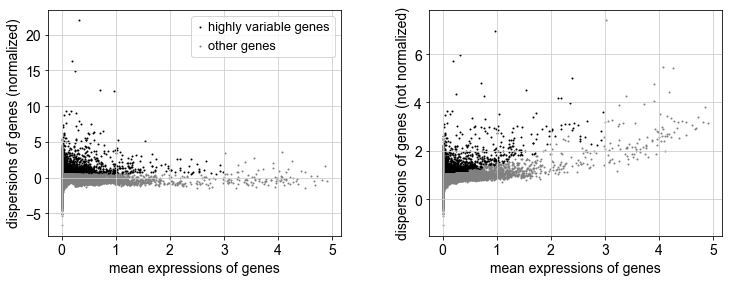

Highly variable genes: 2472


In [5]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5)

sc.pl.highly_variable_genes(adata2)

print("Highly variable genes: %d"%sum(adata2.var.highly_variable))

var_genes_all = adata2.var.highly_variable

#INTEG_5_SCANPY:

In [6]:
sc.pp.highly_variable_genes(adata2, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'lib_prep')

print("Highly variable genes intersection: %d"%sum(adata2.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata2.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata2.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 748
Number of batches where gene is variable:
0    10788
1     3923
2     1307
3      748
Name: highly_variable_nbatches, dtype: int64


Compare overlap of the variable genes.

In [7]:
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata2.var.highly_variable_nbatches ==3))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata2.var.highly_variable_intersection))


Any batch var genes: 5978
All data var genes: 0
Overlap: 0
Variable genes in all batches: 748
Overlap batch instersection and all: 0


Select all genes that are variable in at least 2 datasets and use for remaining analysis. 

In [8]:
var_select = adata2.var.highly_variable_nbatches > 1
var_genes = var_select.index[var_select]
len(var_genes)



2055

### Data integration

First we need to create individual AnnData objects from each of the datasets.

In [9]:
# split per batch into new objects.
batches = ['v2','v3','p3']
alldata = {}
for batch in batches:
    alldata[batch] = adata2[adata2.obs['lib_prep'] == batch,]

alldata    

{'v2': View of AnnData object with n_obs × n_vars = 932 × 16766 
     obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'percent_ribo', 'n_genes'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection',
 'v3': View of AnnData object with n_obs × n_vars = 1069 × 16766 
     obs: 'batch', 'lib_prep', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'percent_mito', 'n_counts', 'per

Then perform batch correction with MNN. 

The function mnn_correct has the following input options:

```    
scanpy.api.pp.mnn_correct(*datas, var_index=None, var_subset=None, 
 batch_key='batch', index_unique='-', batch_categories=None, k=20, 
 sigma=1.0, cos_norm_in=True, cos_norm_out=True, svd_dim=None, 
 var_adj=True, compute_angle=False, mnn_order=None, svd_mode='rsvd', 
 do_concatenate=True, save_raw=False, n_jobs=None, **kwargs)
```

We run it with the option `save_raw=True` so that the uncorrected matrix will be stored in the slot `raw`.

In [10]:
cdata = sc.external.pp.mnn_correct(alldata['v2'],alldata['v3'],alldata['p3'], batch_key = 'lib_prep', save_raw = True, var_subset = var_genes)



Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 2: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
Step 2 of 2: processing batch 2
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


#INTEG_10_SCANPY:


In [11]:
corr_data = cdata[0][:,var_genes]

#INTEG_ALL4:

In [12]:
# tSNE
sc.tl.tsne(corr_data, n_pcs = 30)
# UMAP, first with neighbor calculation 
sc.pp.neighbors(corr_data, n_pcs = 30, n_neighbors = 20)
sc.tl.umap(corr_data)


computing tSNE
         Falling back to preprocessing with `sc.pp.pca` and default params.
Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 50
    finished (0:00:00)
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:15)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP


/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


#INTEG_ALL4:

... storing 'batch' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


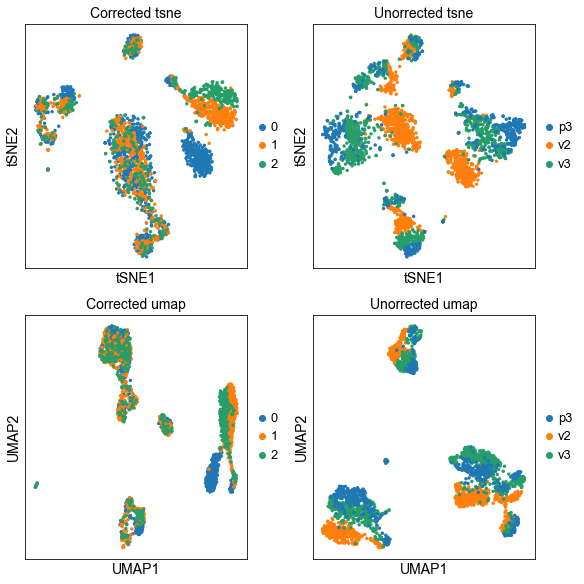

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(corr_data, color="lib_prep", title="Corrected tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="lib_prep", title="Unorrected tsne", ax=axs[0,1], show=False)
sc.pl.umap(corr_data, color="lib_prep", title="Corrected umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="lib_prep", title="Unorrected umap", ax=axs[1,1], show=False)


#INTEG_ALL5:

In [14]:
save_file = './data/scanpy_mnn_corrected_3pbmc.h5ad'
corr_data.write_h5ad(save_file)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


#INTEG_12_SCANPY:

#INTEG_13_SCANPY:

In [15]:
sc.pp.combat(adata2, key='lib_prep')

Standardizing Data across genes.

Found 3 batches

Found 0 numerical variables:
	

Found 21 genes with zero variance.
Fitting L/S model and finding priors

Finding parametric adjustments



/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:235: RuntimeWarning: invalid value encountered in true_divide
  b_prior[i],
/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/scanpy/preprocessing/_combat.py:235: RuntimeWarning: divide by zero encountered in true_divide
  b_prior[i],


Adjusting data



extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes: 2975


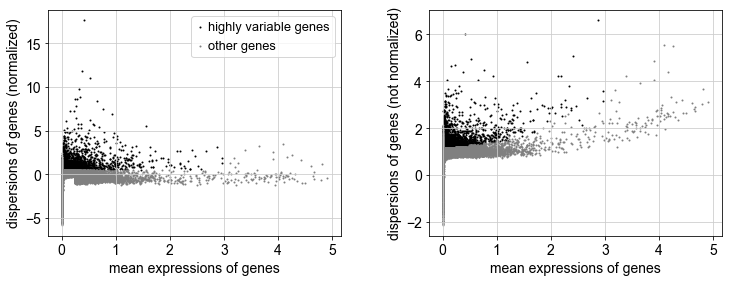

computing PCA with n_comps = 30
computing PCA on highly variable genes
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP


/Users/asbj/miniconda3/envs/sc_course/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing tSNE
    using 'X_pca' with n_pcs = 30
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:15)


In [20]:
sc.pp.highly_variable_genes(adata2)
print("Highly variable genes: %d"%sum(adata2.var.highly_variable))
sc.pl.highly_variable_genes(adata2)

sc.pp.pca(adata2, n_comps=30, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata2)

sc.tl.umap(adata2)
sc.tl.tsne(adata2, n_pcs = 30)

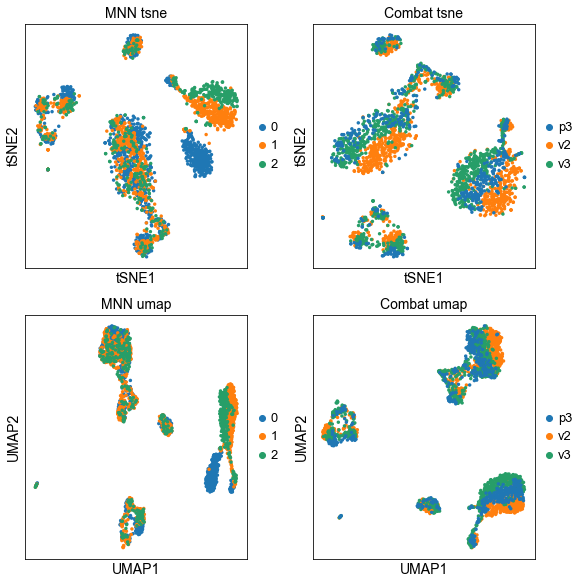

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(8,8),constrained_layout=True)
sc.pl.tsne(corr_data, color="lib_prep", title="MNN tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata2, color="lib_prep", title="Combat tsne", ax=axs[0,1], show=False)
sc.pl.umap(corr_data, color="lib_prep", title="MNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata2, color="lib_prep", title="Combat umap", ax=axs[1,1], show=False)

In [ ]:
save_file = './data/scanpy_mnn_corrected_3pbmc.h5ad'
corr_data.write_h5ad(save_file)